In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
nysdr=pd.read_csv('nysdr.csv')
nysdr=nysdr.drop('Unnamed: 0',axis=1)
df=nysdr.copy()
nysdr.dtypes

Malpractice     object
Boro            object
Name            object
Specialty       object
School          object
Year             int64
State           object
Country         object
Num_Payments     int64
dtype: object

In [4]:
#create empty columns
df['Num_Payments']=df['Num_Payments'].apply(lambda x: int(x))
df['ind_law_suit']=df['Num_Payments']
df['year']=df['Num_Payments']
df['mm-yyyy']=df['Num_Payments']
df['date']=df['Num_Payments']
df['area']=df['Num_Payments']
df['significance']=df['Num_Payments']

In [5]:
def extract_law_suit_info(deets,ind):
    tmp_mal_rows=pd.DataFrame(columns=df.columns)
    for d in range(1,len(deets)):
        suit_info={}
        suit_info['ind_law_suit']=d
        date=re.search('(..-..-....)', deets[d])
        suit_info['date'] = date.group()
        month=date.group()[:2]
        suit_info['year']=date.group()[6:]
        suit_info['mm-yyyy']=month+'-'+date.group()[6:]
        # area might be zip code or County, State
        try:
            area=re.search('\d{5}',deets[d].strip())
            suit_info['area'] = area.group()
            suit_info['significance']= deets[d].strip()[area.span()[1]+1:]
        except:
            try:
                _,end=date.span()
                area_obj=re.search('[A-Za-z]* *[\w]*(, NY)',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
            except:
                _,end=date.span()
                area_obj=re.search('Not Available',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
        tmp_row=pd.DataFrame([df.loc[ind]],columns=df.columns)
        tmp_row['date']=suit_info['date']
        tmp_row['year']=suit_info['year']
        tmp_row['mm-yyyy']=suit_info['mm-yyyy']
        tmp_row['area']=suit_info['area']
        tmp_row['significance']=suit_info['significance']
        tmp_row['ind_law_suit']=suit_info['ind_law_suit']
        tmp_mal_rows=pd.concat([tmp_mal_rows, tmp_row], axis=0)
    return tmp_mal_rows

In [6]:
# Fill in Law Suit info!
# creates empty data frame to fill
malpractice=pd.DataFrame(columns=df.columns)
for ind in range(len(df)):
    #print(ind)
    mal=df.Malpractice[ind]
    if mal=='None reported':
        continue
    start,end =re.search('High   |   Low\n',mal).span()
    start2,end2=re.search("\n\nThe doctor\'s malpractice history",mal).span()
    deets=mal[end:start2].strip()
    deets=deets.split('\n')
    if re.search('None reported',deets[1]) != None:
        x,y=re.search('\n(..-..-....)',mal).span()
        x2,y2=re.search('\n\nSettlements',mal).span()
        deets=[0,mal[x+1:x2]]
    tmp_mal_rows=extract_law_suit_info(deets,ind)
    malpractice=pd.concat([malpractice, tmp_mal_rows], axis=0)
malpractice=malpractice.drop_duplicates(['Name','date'])

In [7]:
malpractice['DateTime']=list(map(lambda x:pd.to_datetime(x),malpractice.date))
malpractice['MonthYear']=list(map(lambda x:pd.to_datetime(x),malpractice['mm-yyyy']))
malpractice['YearLS']=list(map(lambda x:pd.to_datetime(x),malpractice['year']))

# malpractice.set_index('DateTime')
# malpractice.index.month
ts=malpractice.groupby("MonthYear").agg(len)

In [8]:
# malpractice.loc[malpractice.DateTime=='2008-11-17']
# malpractice.sample()

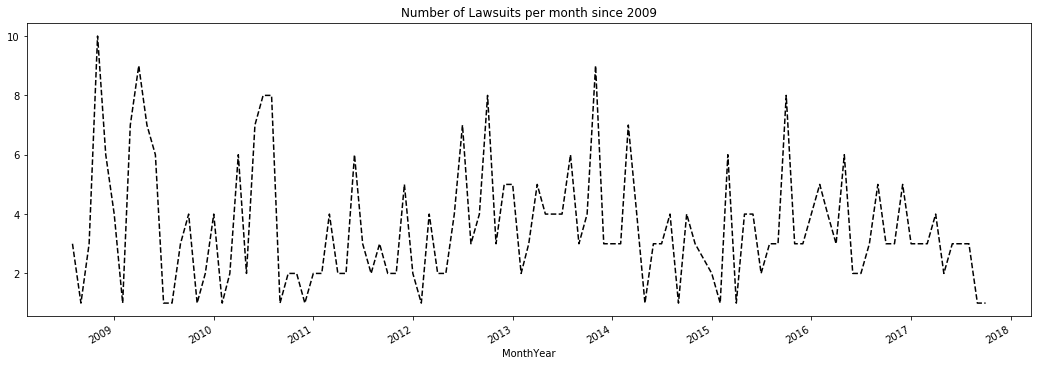

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize']=18,6 # change plot size

plt.figure(); ts['Malpractice'].plot(style='k--', title="Number of Lawsuits per month since 2009",label='Series');

In [10]:
ts_year=malpractice.groupby("YearLS").agg(len)['Malpractice']
ts_year

YearLS
2008-01-01    23
2009-01-01    46
2010-01-01    44
2011-01-01    35
2012-01-01    45
2013-01-01    52
2014-01-01    36
2015-01-01    40
2016-01-01    45
2017-01-01    23
Name: Malpractice, dtype: int64

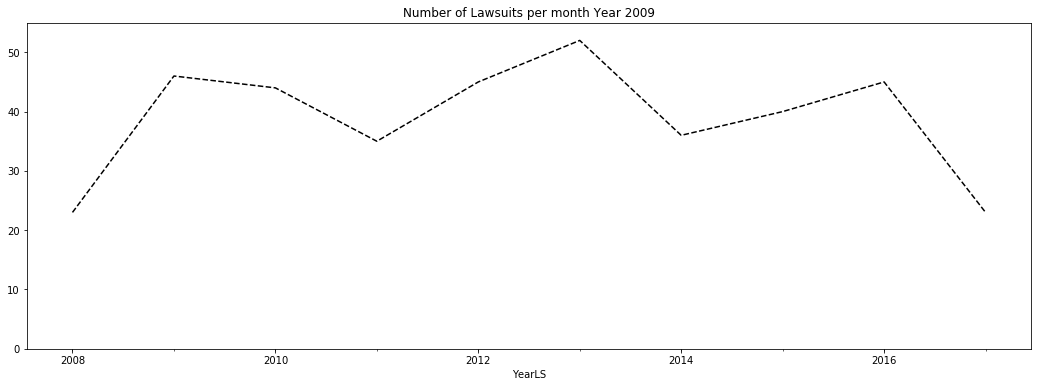

In [11]:
%matplotlib inline
plt.rcParams['figure.figsize']=18,6 # change plot size

plt.figure(); ts_year.plot(style='k--', title="Number of Lawsuits per month Year 2009",label='Series',ylim=(0,55));

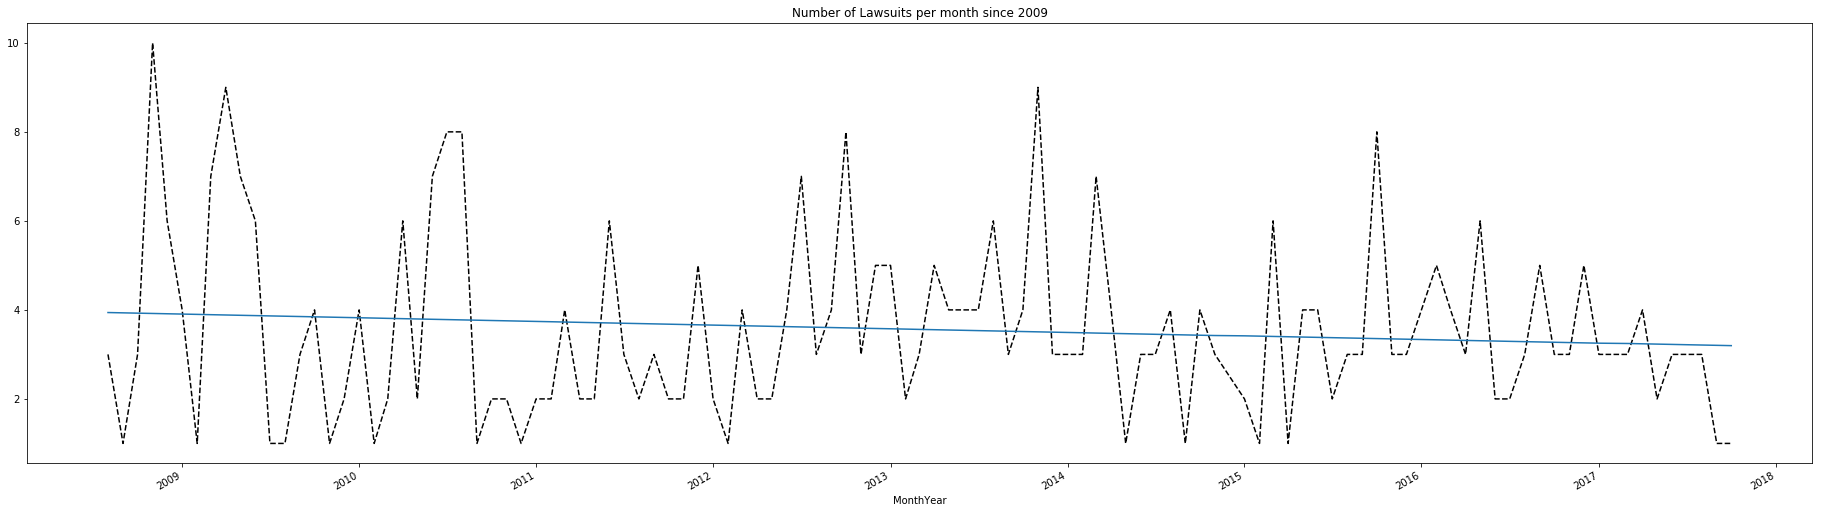

In [12]:
x=range(len(ts))
y=ts['Malpractice']

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.rcParams['figure.figsize']=32,9 # change plot size

plt.figure(); 
ts['Malpractice'].plot(style='k--', title="Number of Lawsuits per month since 2009",label='Series');
plt.plot(ts.index,fit_fn(x));

In [13]:
# Slope is just barely negative
np.polyfit(x,y,1)

array([-0.00688537,  3.94061718])

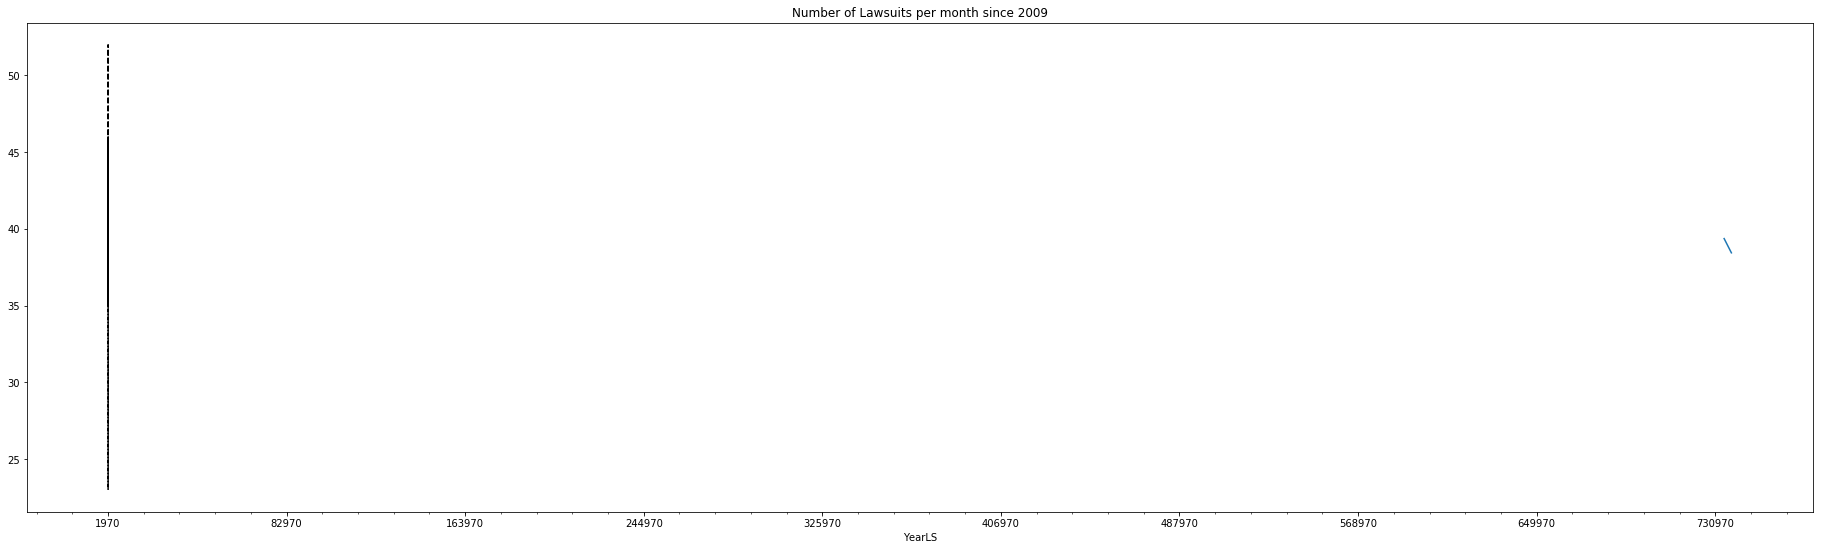

In [23]:
x=range(len(ts_year))
y=ts_year

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.rcParams['figure.figsize']=32,9 # change plot size

plt.figure(); 
ts_year.plot(style='k--', title="Number of Lawsuits per month since 2009",label='Series');
plt.plot(ts_year.index,fit_fn(x)); #

In [20]:
ts_year.index

DatetimeIndex(['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', name='YearLS', freq=None)

In [22]:
fit_fn(x)

array([39.36363636, 39.26060606, 39.15757576, 39.05454545, 38.95151515,
       38.84848485, 38.74545455, 38.64242424, 38.53939394, 38.43636364])